We often need to cluster nodes together. 
There are two main cases: 1. clustering of the graph itself, and 2. clustering
of data points based on some property. Such a case is for instance needed when 
clustering neurons based on the similarity of their input-output properties.

This notebooks aims at comparing implemented methods.

# I. Clustering of the graph itself

# II. Clustering of data points based on some property
Example for the beanchmarking: cluster motor neurons in T3 based on their cosine
similarity in terms of inputs.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import specific_neurons.mdn_helper as mdn_helper
import specific_neurons.motor_neurons_helper as mns_helper

In [3]:
full_VNC = mdn_helper.get_vnc_split_MDNs_by_neuropil(
    not_connected=mdn_helper.get_mdn_bodyids()
)
VNC = full_VNC.get_connections_with_only_traced_neurons()
motor_neurons = mns_helper.get_leg_motor_neurons(VNC, leg="h", side="RHS")

Loaded VNC Connections object with MDNs split by neuropil.
Attribute status:string not found in the graph. Adding it.
Attribute class:string not found in the graph. Adding it.


### A. hierarchical with matrix traverse

In [4]:
# Restricting
cmatrix_1 = VNC.get_cmatrix(type_="unnorm")
premotor_neurons = cmatrix_1.list_upstream_neurons(motor_neurons)
nodes = list(set(motor_neurons).union(premotor_neurons))
cmatrix_1.restrict_nodes(nodes)

# Clustering
(
    clustered_cmatrix_1, # clustered similarity matrix as cmatrix object
    uid_clusters_1, # list of lists of uids in each cluster
    index_clusters_1, # list of lists of indices in each cluster matching the clustered cmatrix
) = cmatrix_1.detect_clusters(
    distance="cosine",
    method="hierarchical",
    cutoff=0.5,
    cluster_size_cutoff=2,
    cluster_data_type="uid",
    cluster_on_subset = motor_neurons,
)

/home/hurtak/vnc_networks/vnc_networks/cmatrix.py:657: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = sch.linkage(matrix_, method="ward")
/home/hurtak/miniconda3/envs/vnc/lib/python3.12/site-packages/numpy/matrixlib/defmatrix.py:446: RuntimeWarning: Mean of empty slice.
  return N.ndarray.mean(self, axis, dtype, out, keepdims=True)._collapse(axis)
/home/hurtak/miniconda3/envs/vnc/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


[200961, 196105, 234250, 150028, 128269, 133902, 271884, 59155, 165652, 179220, 282135, 170008, 164636, 209445, 179752, 100908, 49727, 147013, 342600, 348246, 142169, 313690, 363358, 308578, 189539, 125284, 62823, 292459, 73585, 150900, 76149, 17275, 68475, 239487, 281729, 196994, 28035, 7556, 325762, 62087, 123784, 301191, 347278, 103421, 253593, 99231, 12703, 173727, 341157, 263334, 365224, 257193, 350380, 364717, 287150, 311736, 85961, 25293, 44498, 121815, 258777, 120030, 307937, 28387, 139514, 304366, 135665, 303089, 238582, 314359, 308986, 208381, 171144, 109705, 299656, 227597, 291605, 294173, 278437, 73766, 114480, 161973, 11832, 246719, 12488, 364104, 118219, 297805, 60895, 303595, 76660, 88185, 361724, 79524, 261668, 331368, 69164, 185819, 293915, 249343, 157472, 248673, 113186, 138179, 316707, 111109, 362984, 168649, 181807, 54841, 194481, 60498, 273969, 212727, 127257, 235965, 229541, 84583, 224489, 195213, 95534, 154800, 231857, 147379, 263285, 101974, 126488, 287355, 2707

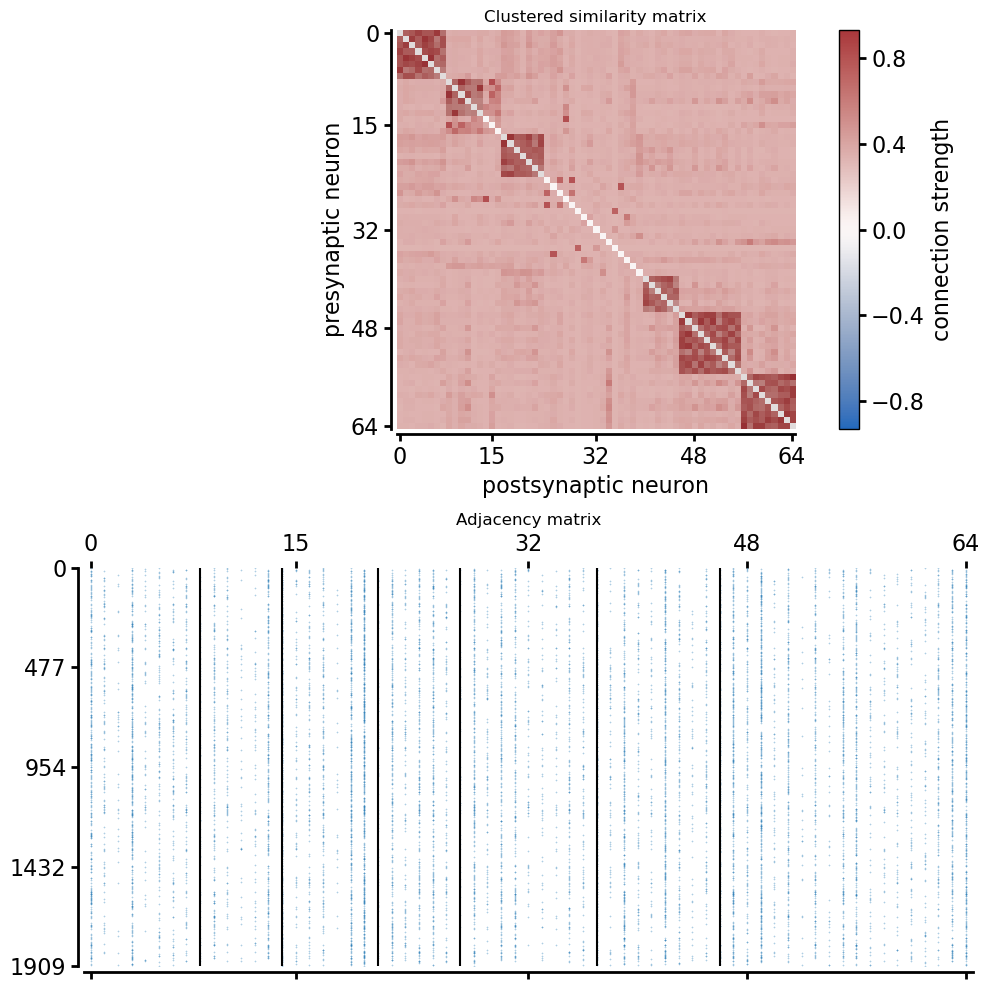

In [5]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Left: visualise similarity data
clustered_mat = clustered_cmatrix_1.get_matrix().todense()
# create a matrix of zeros
mat = np.zeros((clustered_mat.shape[0], clustered_mat.shape[1]))
# draw the boundaries between clusters
for cluster in index_clusters_1:
    mat[cluster[0] : cluster[-1] + 1, cluster[0] : cluster[-1] + 1] = 1
_ = clustered_cmatrix_1.imshow(savefig=False, ax=axs[0], title="Clustered similarity matrix")
axs[0].imshow(mat, cmap="binary", alpha=0.1)

# Right: visualise the initial adjacency matrix where the rows are the premotor
# neurons and the columns are the motor neurons, and the premotor neurons are
# ordered according to the clusters, with vertical lines separating the clusters
sorted_motor_neurons = [n for cluster in uid_clusters_1 for n in cluster]
sorted_motor_neurons.extend(
    list(set(motor_neurons).difference(set(sorted_motor_neurons)))
    )
# sort premotor neurons: find the premotor neurons that project to at least 
# x% of the motor neurons in a given cluster, and sort them according to the
# clusters. Append the others at the end.
sorted_premotor_neurons_1 = []
for cluster in uid_clusters_1:
    to_add = cmatrix_1.list_neurons_upstream_set(cluster, ratio=1)
    sorted_premotor_neurons_1.extend(
        list(set(to_add).difference(set(sorted_premotor_neurons_1))) # avoid duplicates
        )
sorted_premotor_neurons_1.extend(
    list(set(premotor_neurons).difference(set(sorted_premotor_neurons_1))) # complete
    )

# restrict the adjacency matrix to the premotor neurons and the motor neurons
cmatrix_1.restrict_from_to(
    sorted_premotor_neurons_1,
    sorted_motor_neurons,
    input_type="uid"
    )
print(sorted_premotor_neurons_1)
lookup = cmatrix_1.get_lookup()
lookup.sort_values(by="row_index", inplace=True)
print(lookup)
_ = cmatrix_1.spy(savefig=False, ax=axs[1], title="Adjacency matrix")
sum_c = 0
for i in range(0, len(uid_clusters_1)):
    sum_c += len(index_clusters_1[i])
    axs[1].axvline(sum_c, color="black")
plt.tight_layout()

plt.show()